Using device: cuda


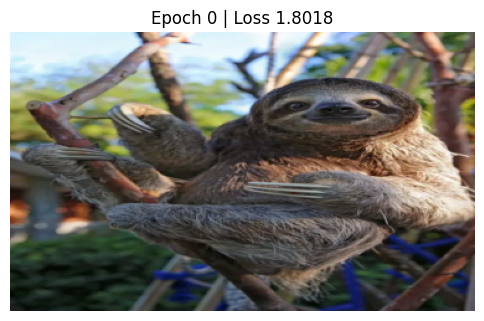

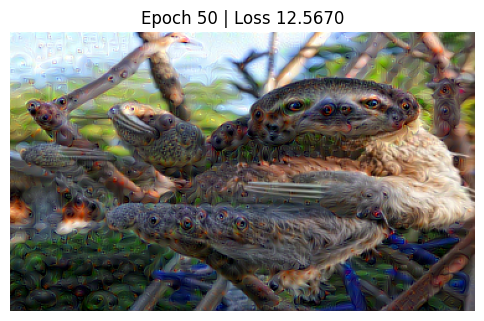

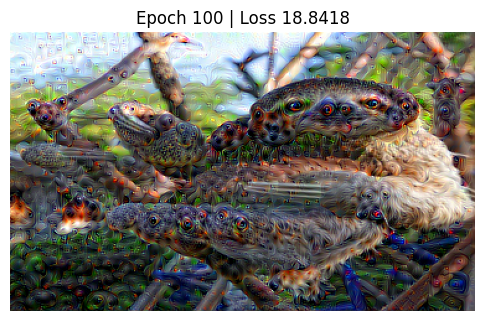

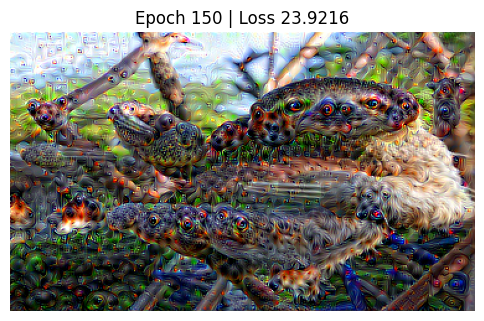

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(device)
vgg.eval()


selected_layers = [17, 24]  # conv3_1, conv4_1


preprocess = transforms.Compose([
    transforms.Resize((225, 375)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

image = Image.open("../Data/sloth.jpg").convert("RGB")
image = preprocess(image).unsqueeze(0).to(device)
image.requires_grad_(True)



def get_activations(model, x, layers):
    activations = []
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            activations.append(x)
    return activations



def calculate_loss(image, model, layers):
    activations = get_activations(model, image, layers)
    losses = [act.mean() for act in activations]
    return torch.stack(losses).sum()



def deep_dream_step(model, image, layers, learning_rate):
    model.zero_grad()

    loss = calculate_loss(image, model, layers)
    loss.backward()

    gradients = image.grad
    gradients /= gradients.std() + 1e-8

    with torch.no_grad():
        image += learning_rate * gradients
        image.clamp_(-3, 3)

    image.grad.zero_()
    return loss.item()



def inverse_transform(tensor):
    tensor = tensor.detach().cpu().squeeze(0)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()




def run_deep_dream(model, image, layers, epochs=200, learning_rate=0.01):
    for epoch in range(epochs):
        loss = deep_dream_step(model, image, layers, learning_rate)

        if epoch % 50 == 0:
            # --- Show the current dreamed image ---
            plt.figure(figsize=(6,6))
            plt.imshow(inverse_transform(image))
            plt.title(f"Epoch {epoch} | Loss {loss:.4f}")
            plt.axis("off")
            plt.show()



run_deep_dream(vgg, image, selected_layers, epochs=200, learning_rate=0.01)




Processing scale: 0.5
  Epoch 0 | Loss 2.7575
  Epoch 40 | Loss 13.6873
Processing scale: 0.75
  Epoch 0 | Loss 5.5485
  Epoch 40 | Loss 18.5648
Processing scale: 1.0
  Epoch 0 | Loss 8.4368
  Epoch 40 | Loss 20.1708


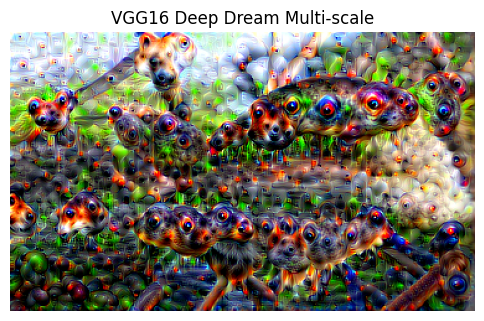

In [65]:
def deep_dream_multiscale(model, image, layers, scales=(0.5,0.75,1.0), epochs=80, learning_rate=0.01):
    base_image = image.detach()

    for scale in scales:
        print(f"Processing scale: {scale}")

        height = int(base_image.shape[2] * scale)
        width = int(base_image.shape[3] * scale)

        dream_image = nn.functional.interpolate(base_image, size=(height, width), mode='bilinear', align_corners=False)
        dream_image.requires_grad_(True)

        for epoch in range(epochs):
            loss = deep_dream_step(model, dream_image, layers, learning_rate)

            if epoch % 40 == 0:
                print(f"  Epoch {epoch} | Loss {loss:.4f}")

        base_image = nn.functional.interpolate(dream_image.detach(), size=base_image.shape[-2:], mode='bilinear', align_corners=False)
    return base_image


dreamed = deep_dream_multiscale(vgg, image, selected_layers, scales=(0.5,0.75,1.0), epochs=80, learning_rate=0.01)
plt.figure(figsize=(6,6))
plt.imshow(inverse_transform(dreamed))
plt.title("VGG16 Deep Dream Multi-scale")
plt.axis("off")
plt.show()